<a href="https://colab.research.google.com/github/JihoonPark99/NLP_study/blob/main/_11_CNN_%EC%8A%A4%ED%8C%B8_%EB%A9%94%EC%9D%BC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN 스팸 메일 분류

- RNN이나 CNN을 이용한게 아니라,
- conv1D를 이용했다. 




### 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer ##토큰나이저
from tensorflow.keras.preprocessing.sequence import pad_sequences ##길이 맞춰주는 패딩시퀀스

* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

#### 데이터 로드

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename = 'spam.csv')
data = pd.read_csv('spam.csv', encoding='latin-1')
print(len(data))
##전체개수는 5572개

5572


In [ ]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


#### 쓸모없는 열 삭제

In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham', 'spam'], [0,1])
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


#### 중복내용 드랍 : drop_duplicates
-  https://wikidocs.net/154060

In [ ]:
##중복내용 드랍시키기
data.drop_duplicates(subset=['v2'], inplace=True)

#drop_duplicates : https://wikidocs.net/154060
len(data)

5169

#### 시각화

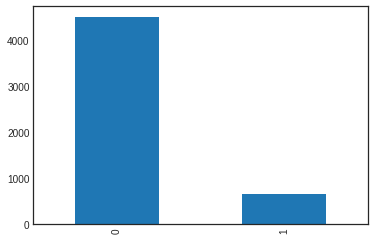

In [ ]:
data['v1'].value_counts().plot(kind='bar')

##스팸보단 정상메일이 많음

#### confusion matrix

In [ ]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


#### 토큰화
- Tokenizer
- texts_to_sequences

In [ ]:
X_data = data['v2']
Y_data = data['v1']

In [ ]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data)

sequences = tokenizer.texts_to_sequences(X_data)

In [ ]:
sequences[:3]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6],
 [53,
  537,
  8,
  20,
  4,
  934,
  2,
  220,
  706,
  267,
  70,
  2,
  2,
  359,
  537,
  604,
  82,
  436,
  185,
  707,
  437]]

#### 길이 맞추주기(pad_sequences)

In [ ]:
X_data = sequences

print('메일 최대 길이 : {}'.format(max(len(l) for l in X_data)))
print('메일 평균 길이 : {}'.format((sum(map(len, X_data))/len(X_data))))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


Text(0, 0.5, 'Number of Samples')

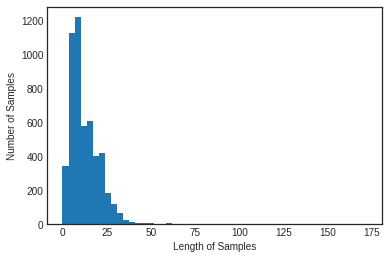

In [ ]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')


60정도까지 자르자 (그 위에것들은 거의 분포가 없다.)

In [ ]:
max_len = 60
data  = pad_sequences(X_data, maxlen=max_len)
print(data.shape)

(5169, 60)


In [ ]:
len(sequences)

5169

#### X_train, 

In [ ]:
##train, test개수 맞추기
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

print(n_train)
print(n_test)

4135
1034


In [ ]:
X_train = data[:n_train] ##댓글 내용
y_train = np.array(Y_data[:n_train]) ##스팸인지 아닌지

X_test = data[n_train:]
y_test = np.array(Y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding,Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) #binary니까 시그모이드로 해주자.
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

- 파라미터 수가 4만개가 되지 않는다.
- 좀 작은 모델

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
##verbose : {'1' : 출력, '0' : 출력안함}

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 모델 학습

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs = 10, 
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es,mc])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.4967 - acc: 0.8464
Epoch 1: val_acc improved from -inf to 0.87304, saving model to best_model.h5
52/52 [==============================] - 10s 10ms/step - loss: 0.4967 - acc: 0.8464 - val_loss: 0.3775 - val_acc: 0.8730
Epoch 2/10
51/52 [============================>.] - ETA: 0s - loss: 0.3730 - acc: 0.8692
Epoch 2: val_acc did not improve from 0.87304
52/52 [==============================] - 0s 6ms/step - loss: 0.3716 - acc: 0.8697 - val_loss: 0.3267 - val_acc: 0.8730
Epoch 3/10
51/52 [============================>.] - ETA: 0s - loss: 0.2049 - acc: 0.9151
Epoch 3: val_acc improved from 0.87304 to 0.98428, saving model to best_model.h5
52/52 [==============================] - 0s 5ms/step - loss: 0.2029 - acc: 0.9163 - val_loss: 0.0939 - val_acc: 0.9843
Epoch 4/10
41/52 [======================>.......] - ETA: 0s - loss: 0.0705 - acc: 0.9825
Epoch 4: val_acc did not improve from 0.98428
52/52 [===========================

### 시각화

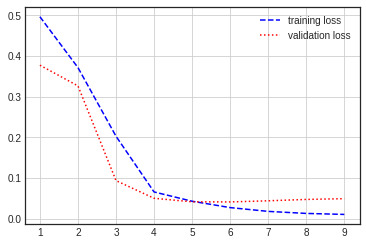

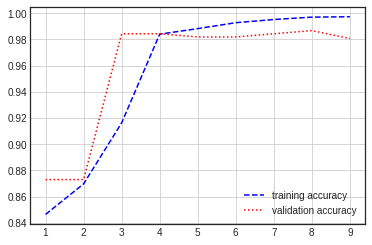

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label = 'training accuracy')
plt.plot(epochs, val_acc, 'r:', label='validation accuracy')
plt.grid()
plt.legend()

plt.show()


아주 훌륭하게 잘 학습이 됐다.
- 오버피팅도 안됐다. 

In [ ]:
model.evaluate(X_test, y_test)

##높은 성능을 분류가 됐다. 

33/33 [==============================] - 0s 3ms/step - loss: 0.0687 - acc: 0.9797


[0.06866907328367233, 0.9796905517578125]